In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error   
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import mlflow
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor

In [38]:
class Regression:

    def __init__(self, data:pd.DataFrame, target_column:str, train_size:float=0.6, test_size:float=0.2, datetime_column:str=None, random_state:int=0):

        if datetime_column== None:
            data = data.reset_index(drop=True).reset_index()
            datetime_column= 'index'
        self.data= data
        self.datetime_column = datetime_column
        self.target_column = target_column

        # Dropping nan values
        data= data.dropna()

        # Raising exception if data is not present
        if data.shape[0] == 0:
            raise NoDataPresentException
        
        # sorting values accoriding to datetime
        data = data.sort_values(by = self.datetime_column, ascending = True)
        self.data_test = data.tail(int(test_size*len(data)))

        data = data.drop(self.data_test.index)
        self.y = data[target_column]
        self.X = data.drop(target_column, axis = 1)
        self.X_test = self.data_test.drop(target_column, axis = 1)
        self.y_test = self.data_test[target_column]
        self.data_for_graph= {}

        self.train_size = train_size*len(self.X)        
        self.random_state = random_state
        
        self.x_train, self.x_valid, self.y_train, self.y_valid = train_test_split(self.X, self.y, train_size = self.train_size, random_state = self.random_state)
        self.x_valid1 = self.x_valid.drop(self.datetime_column, axis = 1)
        self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1)

    
    @staticmethod
    def evaluate(test:pd.Series, preds: pd.Series, process:str)->tuple:
        score=r2_score(test,preds)
        mse = mean_squared_error(test,preds)
        rmse = np.sqrt(mean_squared_error(test,preds))
        mape = mean_absolute_percentage_error(test,preds)
        mae= mean_absolute_error(test, preds)

        print('For {}'.format(process))
        print('r2_score: {}\nmse:{}\nrmse:{}\nmape:{}\nmae:{}'.format(score, mse, rmse, mape, mae))

        return (score, mse, rmse, mape, mae)



class Regressor(Regression):


    def __init__(self, 
                data:pd.DataFrame, 
                target_column:str,
                model_type:str='LinearRegression',
                train_size:float=0.6,
                test_size:float=0.2, 
                datetime_column:str=None,
                train_size:int=0.6,
                random_state:int=0,
                **kwargs)->self:

        self.model_assignment= {
                                'LinearRegression': LinearRegression,
                                'SGDRegressor': SGDRegressor,
                                'Lasso': Lasso,
                                'ElasticNet': ElasticNet,
                                'Ridge': Ridge,
                                'SVR': SVR,
                                'AdaboostRegressor': AdaBoostRegressor,
                                'BaggingRegressor': BaggingRegressor,
                                'HistGradientBoostingRegressor':  HistGradientBoostingRegressor,
                                'VotingRegressor': VotingRegressor,
                                'StackingRegressor': StackingRegressor,
                                'GradientBoostingRegressor': GradientBoostingRegressor,
                                'ExtraTreesRegressor':ExtraTreesRegressor,
                                'XGBRegressor': XGBRegressor
                                }
        super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)
        session = mlflow.start_run()
        
        with session :
            
            ## Building a model
            self.model =  self.model_assignment[model_type](**kwargs)#LinearRegression(**kwargs)
            self.model.fit(self.x_train1,self.y_train)
            
            ## On Training Data:
            y_pred_train = self.model.predict(self.x_train1)
            (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
            self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            ## On Validation Data:
            y_pred_valid = self.model.predict(self.x_valid1)
            (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
            self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            ## On Test data: 
            y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
            (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
            self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

            # Log parameters and metrics to MLflow
            mlflow.log_param("train_size", self.train_size)
            mlflow.log_param("random_state", self.random_state)
            mlflow.log_param("model_type", model_type)
            params= self.model.get_params()
            for param in params.keys():
                mlflow.log_params(param, params[param])

            mlflow.log_metric("r2_score_train", self.train_score)
            mlflow.log_metric("mse_train", self.train_mse)
            mlflow.log_metric("rmse_train", self.train_rmse)
            mlflow.log_metric("mape_train", self.train_mape)
            mlflow.log_metric("mae_train", self.train_mae)

            mlflow.log_metric("r2_score_valid", self.valid_score)
            mlflow.log_metric("mse_valid", self.valid_mse)
            mlflow.log_metric("rmse_valid", self.valid_rmse)
            mlflow.log_metric("mape_valid", self.valid_mape)
            mlflow.log_metric("mae_valid", self.valid_mae)

            mlflow.log_metric("r2_score_test", self.test_score)
            mlflow.log_metric("mse_test", self.test_mse)
            mlflow.log_metric("rmse_test", self.test_rmse)
            mlflow.log_metric("mape_test", self.test_mape)
            mlflow.log_metric("mae_test", self.train_mae)

            mlflow.sklearn.log_model(self.model, "model")
            
            return self

    def tune(**kwargs):
        def objective(trial):
            params=self.get_params()
            param= 
            n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
            max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
            regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
            return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv['cv'])).mean()
            

# class LinearRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session :
            
#             ## Building a model
#             self.model =  LinearRegression(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#         def tune(self, ):
#             pass


# class SGDRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  SGDRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "SGDRegressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class Lasso(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  Lasso(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Lasso")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class ElasticNet(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  ElasticNet(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "ElasticNet")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class Ridge(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  Ridge(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Ridge")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class SVR(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  SVR(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "SVR")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class AdaboostRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  AdaboostRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class BaggingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  BaggingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class HistGradientBoostingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  HistGradientBoostingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class VotingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  VotingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class StackingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  StackingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class ExtraTreesRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  ExtraTreesRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class GradientBoostingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  GradientBoostingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class RandomForestRegressor(Regression):
#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:

#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)
#         session = mlflow.start_run()
#         with session :
            
#             ## Building a model
#             self.model =  RandomForestRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.result_OOT = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Random Forest Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#     def tune(self,
#             n_estimators_range:list=[1, 10], 
#             max_depth_range:list=[1, 9], 
#             scoring = 'neg_mean_absolute_percentage_error', 
#             n_trials:int=100, 
#             cv:dict={'cv': 3, 'n_splits': 10, 'n_repeats': 3, 'random_state'=1, 'n_jobs': -1},
#             buttons:dict=None)->self:

#         def objective(trial):
#             n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
#             max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
#             regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
#             return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv['cv'])).mean()

#         # OPTUNA APPLICATION
#         if 'score' in scoring:
#             study = optuna.create_study(direction='maximize')
#         else:
#             study = optuna.create_study(direction='minimize')

#         study.optimize(objective, n_trials=n_trials)
#         trial = study.best_trial   
#         lg.info('\t\tAccuracy: {}'.format(trial.value))
#         lg.info("\t\tBest hyperparameters: {}".format(trial.params))
#         self.optimization_traectory= optuna.visualization.plot_optimization_history(study)

#         # Random Forest: final best model   
#         session = mlflow.start_run()
#         with session :
#             # Building the model
#             self.model = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth= trial.params['max_depth'])

#             # Cross Validation
#             cv = RepeatedKFold(n_splits=cv['n_splits'], n_repeats=cv['n_repeats'], random_state=cv['random_state'])
#             scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv['cv'], n_jobs=cv['n_jobs'])
#             scores = np.absolute(scores)
#             mlflow.log_metric("Cross Validation: mean_{}".format(scoring), scores.mean())
#             mlflow.log_metric("Cross Validation: std_{}".format(scoring), scores.std())
            

#             # Model fitting
#             self.model.fit(self.x_train1, self.y_train)
        
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Random Forest Regressor")
#             for param in trial.param.keys():
#                 mlflow.log_params(param, trial.params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             return self 

# class XGBRegressor(Regression):
#     def __init__(self,
#                  data:pd.DataFrame, 
#                  target_column:str, 
#                  test_size:float=0.2, 
#                  datetime_column:str=None,
#                  train_size:int=0.6, 
#                  random_state:int=0, 
#                  **kwargs)-> self:
                 
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)      
#         session = mlflow.start_run()
#         with session : 
            
#             ## Building a model
#             self.model =  XGBRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'OOT')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", train_size)
#             mlflow.log_param("random_state", random_state)
#             mlflow.log_param("model_type", "XGBoost Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#     def tune(n_estimators_range:list=[1, 10], 
#             max_depth_range:list=[1, 10], 
#             reg_lambda_range:list=[0, 10], 
#             eta_range:list=[0.001, 1], 
#             alpha_range=[0, 10], 
#             scoring:str='neg_mean_absolute_percentage_error', 
#             n_trials = 100, 
#             cv=5)->self:
#         def objective(trial):
#             n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
#             max_depth = trial.suggest_int('max_depth', max_depth_range[0], max_depth_range[1])
#             reg_lambda = trial.suggest_float('reg_lambda', reg_lambda_range[0], reg_lambda_range[1])
#             eta = trial.suggest_float("eta", eta_range[0], eta_range[1])
#             gamma = trial.suggest_float('gamma', 0.0, 1.0)
#             alpha = trial.suggest_float("alpha", alpha_range[0], alpha_range[1])
#             regressor = XGBRegressor(n_estimators = n_estimators, eta= eta, max_depth = max_depth, alpha = alpha, reg_lambda= reg_lambda)
#             return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()

class DecideForMe(Regression):

def __init__(self, 
            data:pd.DataFrame, 
            target_column:str,
            train_size:float=0.6,
            test_size:float=0.2, 
            datetime_column:str=None,
            train_size:int=0.6,
            random_state:int=0,
            **kwargs)->self:    
    
    # Will be using scikit-learn's cheat-sheet here:
    super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

    # First step: To check whether the data shape is >100K or not
    data_size= self.data.shape[0]
    correlation_matrix= self.data.corr()
    
    if data_size > 100000:
        self.required_estimator= SGDRegressor()
    else




        

In [80]:
a= LinearRegression
model=a(fit_intercept= True)

In [103]:
print(SGDRegressor().get_params()['penalty'])


l2


In [100]:
import inspect
signature = inspect.signature(SGDRegressor)
signature.parameters

mappingproxy({'loss': <Parameter "loss='squared_error'">,
              'penalty': <Parameter "penalty='l2'">,
              'alpha': <Parameter "alpha=0.0001">,
              'l1_ratio': <Parameter "l1_ratio=0.15">,
              'fit_intercept': <Parameter "fit_intercept=True">,
              'max_iter': <Parameter "max_iter=1000">,
              'tol': <Parameter "tol=0.001">,
              'shuffle': <Parameter "shuffle=True">,
              'verbose': <Parameter "verbose=0">,
              'epsilon': <Parameter "epsilon=0.1">,
              'random_state': <Parameter "random_state=None">,
              'learning_rate': <Parameter "learning_rate='invscaling'">,
              'eta0': <Parameter "eta0=0.01">,
              'power_t': <Parameter "power_t=0.25">,
              'early_stopping': <Parameter "early_stopping=False">,
              'validation_fraction': <Parameter "validation_fraction=0.1">,
              'n_iter_no_change': <Parameter "n_iter_no_change=5">,
              

In [131]:
import inspect
from sklearn.linear_model import LinearRegression

# Get the signature of the class initializer
signature = inspect.signature(VotingRegressor.__init__)

# Iterate over the parameters to print their names and default types
for name, param in signature.parameters.items():
    # Skip 'self' which is always the first parameter for class methods
    if name == "self":
        continue
    # If there's a default value, print its type, otherwise print 'No default value'
    # if param.default != inspect.Parameter.empty:
    print(f"{name}: {type(param.default)}, {param.default}")



estimators: <class 'type'>, <class 'inspect._empty'>
weights: <class 'NoneType'>, None
n_jobs: <class 'NoneType'>, None
verbose: <class 'bool'>, False


In [94]:
foo.__annotations__

AttributeError: type object 'LinearRegression' has no attribute '__annotations__'

In [93]:
sig = inspect.signature(a)
[p.annotation for p in sig.parameters.values()]

[inspect._empty,
 inspect._empty,
 inspect._empty,
 inspect._empty,
 inspect._empty]

In [54]:
import pandas as pd
def detect_outliers(data:pd.Series, threshold:float=2.0):
    
    threshold=3  #3 Standard deviations
    mean = data.mean()
    std =data.std()
    z_score= (data- mean)/std
    return z_score[z_score > threshold]

In [52]:
df.corr().abs()['FORCE_2020_LITHOFACIES_LITHOLOGY'].drop('FORCE_2020_LITHOFACIES_LITHOLOGY').sort_values(ascending=False)

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

In [32]:
import panel as pn
float_slider = pn.widgets.EditableFloatSlider(name='Float Slider', start=0, end=100, step=0.1, value=1.57)

pn.serve(float_slider)

Launching server at http://localhost:59142


In [7]:
df= pd.read_csv('test_data.csv')

In [31]:


x = 42
y = 42

name = get_var_name(y)
print(name)

x


In [36]:
temp1 = pn.template.BootstrapTemplate()
temp2= pn.template.FastListTemplate()




a = pn.Tabs(
            ('Template1', temp1),
            ('Template2',  temp2)
            )
pn.serve(a)


Launching server at http://localhost:51016


In [12]:
model_assignment= {
                'LinearRegression': LinearRegression,
                'SGDRegressor': SGDRegressor,
                'Lasso': Lasso,
                'ElasticNet': ElasticNet,
                'Ridge': Ridge,
                'SVR': SVR,
                'AdaboostRegressor': AdaBoostRegressor,
                'BaggingRegressor': BaggingRegressor,
                'HistGradientBoostingRegressor':  HistGradientBoostingRegressor,
                'VotingRegressor': VotingRegressor,
                'StackingRegressor': StackingRegressor,
                'GradientBoostingRegressor': GradientBoostingRegressor,
                'ExtraTreesRegressor':ExtraTreesRegressor,
                'XGBRegressor': XGBRegressor
                }

In [13]:

knowledge= {}
for model in model_assignment.keys():
    knowledge[model] = {}
    signature = inspect.signature(model_assignment[model].__init__)
    for name, param in signature.parameters.items():
        #Iterating over parameters of a single model
        if (name != "self") & (param.default != inspect.Parameter.empty):
            knowledge[model][name]= name
            knowledge[model][name] = {}
            knowledge[model][name]['type']= type(param.default)
            knowledge[model][name]['default'] = param.default

In [26]:
knowledge['LinearRegression']['n_jobs']['type'] == 

True

In [25]:
type(None)

NoneType

In [22]:
a= SGDRegressor()
a.get_params()['loss']

'squared_error'

In [23]:
SGDRegressor.__doc__

"Linear model fitted by minimizing a regularized empirical loss with SGD.\n\n    SGD stands for Stochastic Gradient Descent: the gradient of the loss is\n    estimated each sample at a time and the model is updated along the way with\n    a decreasing strength schedule (aka learning rate).\n\n    The regularizer is a penalty added to the loss function that shrinks model\n    parameters towards the zero vector using either the squared euclidean norm\n    L2 or the absolute norm L1 or a combination of both (Elastic Net). If the\n    parameter update crosses the 0.0 value because of the regularizer, the\n    update is truncated to 0.0 to allow for learning sparse models and achieve\n    online feature selection.\n\n    This implementation works with data represented as dense numpy arrays of\n    floating point values for the features.\n\n    Read more in the :ref:`User Guide <sgd>`.\n\n    Parameters\n    ----------\n    loss : str, default='squared_error'\n        The loss function to be

In [29]:
from sklearn.linear_model import SGDRegressor
import re


def get_parameter_values(estimator, param):
    # Ensure that the given estimator is a class and not an instance
    if not isinstance(estimator, type):
        estimator = type(estimator)
    
    doc = estimator.__doc__
    
    # Find the parameter in the docstring
    matches = re.search(rf'{param} : (.+?)(\n\s+\w+ : |\Z)', doc, re.DOTALL)
    if matches:
        param_str = matches.group(1)
        
        # Extract the possible values for the parameter
        possible_values = re.findall(r"'(.*?)'", param_str)
        return possible_values
    else:
        return []

possible_loss_values = get_parameter_values(ExtraTreesRegressor, 'criterion')
print(possible_loss_values)

[]


In [76]:
a = pn.Row()
a.append(pn.widgets.Toggle(name='1', value=False))
a.append(pn.widgets.TextInput(name='2', value='Hey!'))
a.append(pn.widgets.EditableFloatSlider(name='3', value=1.6, start=0, end=5, step=0.1))

In [77]:
def make_normal_options(widget, default):
    text_field=  pn.widgets.TextInput(name=widget.name, placeholder='defaults to {}'.format(default))
    return pn.Row(widget,text_field)

In [78]:
new= pn.Column()
for i in a:
    new.append(make_normal_options(i, i.value))

In [82]:
new[0][0]

Toggle(name='1')

In [79]:
for i in new:
    print(i[0].name)
    print('\n\n\n\n')

1





2





3







In [92]:
a1= pn.widgets.TextInput(name='Text', placeholder='Enter text')
b1= pn.widgets.EditableFloatSlider(name='Text', start= 0, end= 5, step=0.1)
a1.jslink(b1, value='value', bidirectional=True)

Link(args={}, bidirectional=True, code=None, name='Link01228', properties={'value': 'value'})

In [87]:
pn.serve(b1)

Launching server at http://localhost:54445


In [90]:
pn.extension()

In [91]:
pn.Row(a1, b1)

ModuleNotFoundError: No module named 'jupyter_bokeh'

Row
    [0] TextInput(name='Text', placeholder='Enter text')
    [1] EditableFloatSlider(end=5, name='Text', value=2.7, width=300)

In [59]:
for i in a:
    print(i.name)
    print(i.value)

1
False
2
Hey!
2
1.6


In [61]:
bool('False')

True

In [48]:
for i, j in knowledge['LinearRegression'].items():
    print(i)
    print(j)

fit_intercept
{'type': <class 'bool'>, 'default': True}
copy_X
{'type': <class 'bool'>, 'default': True}
n_jobs
{'type': <class 'NoneType'>, 'default': None}
positive
{'type': <class 'bool'>, 'default': False}


In [27]:
for i in knowledge.keys():
    print(i, knowledge[i])
    print()

LinearRegression {'fit_intercept': {'type': <class 'bool'>, 'default': True}, 'copy_X': {'type': <class 'bool'>, 'default': True}, 'n_jobs': {'type': <class 'NoneType'>, 'default': None}, 'positive': {'type': <class 'bool'>, 'default': False}}

SGDRegressor {'loss': {'type': <class 'str'>, 'default': 'squared_error'}, 'penalty': {'type': <class 'str'>, 'default': 'l2'}, 'alpha': {'type': <class 'float'>, 'default': 0.0001}, 'l1_ratio': {'type': <class 'float'>, 'default': 0.15}, 'fit_intercept': {'type': <class 'bool'>, 'default': True}, 'max_iter': {'type': <class 'int'>, 'default': 1000}, 'tol': {'type': <class 'float'>, 'default': 0.001}, 'shuffle': {'type': <class 'bool'>, 'default': True}, 'verbose': {'type': <class 'int'>, 'default': 0}, 'epsilon': {'type': <class 'float'>, 'default': 0.1}, 'random_state': {'type': <class 'NoneType'>, 'default': None}, 'learning_rate': {'type': <class 'str'>, 'default': 'invscaling'}, 'eta0': {'type': <class 'float'>, 'default': 0.01}, 'power_t':

In [94]:
total=pd.DataFrame()
for i in knowledge.keys():
    total= pd.concat([total, pd.DataFrame(knowledge[i])], axis=1)

In [97]:
total1= total.T
total1[total1['type']==type(None)]

,type,default
n_jobs,<class 'NoneType'>,None
random_state,<class 'NoneType'>,None
random_state,<class 'NoneType'>,None
random_state,<class 'NoneType'>,None
max_iter,<class 'NoneType'>,None
random_state,<class 'NoneType'>,None
estimator,<class 'NoneType'>,None
random_state,<class 'NoneType'>,None
estimator,<class 'NoneType'>,None
n_jobs,<class 'NoneType'>,None


In [5]:
import panel as pn

In [99]:
widget1= pn.widgets.TextInput(name= 'a')
widget2= pn.widgets.TextInput(name= 'b')
c= pn.Row(widget1, widget2)

In [102]:
c[c.name=='a']

ModuleNotFoundError: No module named 'jupyter_bokeh'

TextInput(name='a')

In [7]:
pn.serve(pn.Row(pn.Column(), pn.Card(title= 'AAAAAAAAAAAAAAAAAAAAAH')))

Launching server at http://localhost:62840


In [20]:
total.loc['type', :].unique()

array([<class 'bool'>, <class 'NoneType'>, <class 'str'>, <class 'float'>,
       <class 'int'>], dtype=object)

In [39]:
from dataclasses import make_dataclass, field

# Define a dictionary with parameter names and types
param_dict = {
    "name": str,
    "age": int,
    "is_student": bool
}

# Create a list of Field instances with names and types
fields = [(name, param_type) for name, param_type in param_dict.items()]

# Create a dataclass dynamically using make_dataclass and specify fields
Person = make_dataclass("Person", fields)

# Create an instance of the dataclass
person_instance = Person(name="Alice", age=25, is_student=True)

print(person_instance)


Person(name='Alice', age=25, is_student=True)


In [74]:
from dataclasses import make_dataclass, field
fields = [(param, knowledge['LinearRegression'][param]['type'], field(default=knowledge['LinearRegression'][param]['default'])) for param in knowledge['LinearRegression'].keys()]
linreg= make_dataclass('LinearRegression', fields)

In [82]:
a= linreg
vars(a())

{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False}

In [54]:
from dataclasses import dataclass
@dataclass
class linreg:
    fit_intercept: bool


In [55]:
vars(linreg)

mappingproxy({'__module__': '__main__',
              '__annotations__': {'fit_intercept': bool},
              '__dict__': <attribute '__dict__' of 'linreg' objects>,
              '__weakref__': <attribute '__weakref__' of 'linreg' objects>,
              '__doc__': 'linreg(fit_intercept: bool)',
              '__dataclass_params__': _DataclassParams(init=True,repr=True,eq=True,order=False,unsafe_hash=False,frozen=False),
              '__dataclass_fields__': {'fit_intercept': Field(name='fit_intercept',type=<class 'bool'>,default=<dataclasses._MISSING_TYPE object at 0x000002B4738C9DC0>,default_factory=<dataclasses._MISSING_TYPE object at 0x000002B4738C9DC0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD)},
              '__init__': <function __main__.__create_fn__.<locals>.__init__(self, fit_intercept: bool) -> None>,
              '__repr__': <function __main__.__create_fn__.<locals>.__repr__(self)>,
              '__eq__': <function __main_

In [40]:
print(Person)

<class 'types.Person'>


In [38]:
knowledge

{'LinearRegression': {'fit_intercept': bool,
  'copy_X': bool,
  'n_jobs': NoneType,
  'positive': bool},
 'SGDRegressor': {'loss': str,
  'penalty': str,
  'alpha': float,
  'l1_ratio': float,
  'fit_intercept': bool,
  'max_iter': int,
  'tol': float,
  'shuffle': bool,
  'verbose': int,
  'epsilon': float,
  'random_state': NoneType,
  'learning_rate': str,
  'eta0': float,
  'power_t': float,
  'early_stopping': bool,
  'validation_fraction': float,
  'n_iter_no_change': int,
  'warm_start': bool,
  'average': bool},
 'Lasso': {'alpha': float,
  'fit_intercept': bool,
  'precompute': bool,
  'copy_X': bool,
  'max_iter': int,
  'tol': float,
  'warm_start': bool,
  'positive': bool,
  'random_state': NoneType,
  'selection': str},
 'ElasticNet': {'alpha': float,
  'l1_ratio': float,
  'fit_intercept': bool,
  'precompute': bool,
  'max_iter': int,
  'copy_X': bool,
  'tol': float,
  'warm_start': bool,
  'positive': bool,
  'random_state': NoneType,
  'selection': str},
 'Ridge': {

In [12]:
model_assignment.values()

dict_values([<class 'sklearn.linear_model._base.LinearRegression'>, <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>, <class 'sklearn.linear_model._coordinate_descent.Lasso'>, <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, <class 'sklearn.linear_model._ridge.Ridge'>, <class 'sklearn.svm._classes.SVR'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, <class 'sklearn.ensemble._bagging.BaggingRegressor'>, <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>, <class 'sklearn.ensemble._voting.VotingRegressor'>, <class 'sklearn.ensemble._stacking.StackingRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>, <class 'xgboost.sklearn.XGBRegressor'>])

In [11]:
[*list(model_assignment.values())]

[sklearn.linear_model._base.LinearRegression,
 sklearn.linear_model._stochastic_gradient.SGDRegressor,
 sklearn.linear_model._coordinate_descent.Lasso,
 sklearn.linear_model._coordinate_descent.ElasticNet,
 sklearn.linear_model._ridge.Ridge,
 sklearn.svm._classes.SVR,
 sklearn.ensemble._weight_boosting.AdaBoostRegressor,
 sklearn.ensemble._bagging.BaggingRegressor,
 sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor,
 sklearn.ensemble._voting.VotingRegressor,
 sklearn.ensemble._stacking.StackingRegressor,
 sklearn.ensemble._gb.GradientBoostingRegressor,
 sklearn.ensemble._forest.ExtraTreesRegressor,
 xgboost.sklearn.XGBRegressor]

In [2]:
import inspect
import pandas as pd
knowledge_management= {}
distinct_features= pd.Series()
for model_name in model_assignment.keys():
    knowledge_management[model_name] = {}
    model= model_assignment[model_name]
    signature = inspect.signature(model.__init__)
    for name, param in signature.parameters.items():
        if name == "self":
            continue
        if type(param.default) == str:
            knowledge_management[model_name][name]= [param.default]
        if param.default != inspect.Parameter.empty:
            distinct_features= pd.concat([distinct_features, pd.Series(name)])


C:\Users\sizzl\AppData\Local\Temp\ipykernel_19384\1547374109.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distinct_features= pd.Series()


NameError: name 'model_assignment' is not defined

In [30]:
from dataclasses import make_dataclass

# Define a dictionary with parameter names and types
param_dict = {
    "name": str,
    "age": int,
    "is_student": bool
}

# Create a dataclass dynamically using make_dataclass
Person = make_dataclass("Person", param_dict.keys())

# Create an instance of the dataclass
person_instance = Person(name="Alice", age=25, is_student=True)

print(person_instance)


Person(name='Alice', age=25, is_student=True)


In [18]:
signature = inspect.signature(LinearRegression.__init__)

In [29]:
signature.parameters.items()

odict_items([('self', <Parameter "self">), ('fit_intercept', <Parameter "fit_intercept=True">), ('copy_X', <Parameter "copy_X=True">), ('n_jobs', <Parameter "n_jobs=None">), ('positive', <Parameter "positive=False">)])

In [25]:
a= dict(signature.parameters)
a

{'self': <Parameter "self">,
 'fit_intercept': <Parameter "fit_intercept=True">,
 'copy_X': <Parameter "copy_X=True">,
 'n_jobs': <Parameter "n_jobs=None">,
 'positive': <Parameter "positive=False">}

In [17]:
distinct_features.unique()

array(['fit_intercept', 'copy_X', 'n_jobs', 'positive', 'loss', 'penalty',
       'alpha', 'l1_ratio', 'max_iter', 'tol', 'shuffle', 'verbose',
       'epsilon', 'random_state', 'learning_rate', 'eta0', 'power_t',
       'early_stopping', 'validation_fraction', 'n_iter_no_change',
       'warm_start', 'average', 'precompute', 'selection', 'solver',
       'kernel', 'degree', 'gamma', 'coef0', 'C', 'shrinking',
       'cache_size', 'estimator', 'n_estimators', 'base_estimator',
       'max_samples', 'max_features', 'bootstrap', 'bootstrap_features',
       'oob_score', 'quantile', 'max_leaf_nodes', 'max_depth',
       'min_samples_leaf', 'l2_regularization', 'max_bins',
       'categorical_features', 'monotonic_cst', 'interaction_cst',
       'scoring', 'weights', 'final_estimator', 'cv', 'passthrough',
       'subsample', 'criterion', 'min_samples_split',
       'min_weight_fraction_leaf', 'min_impurity_decrease', 'init',
       'ccp_alpha', 'objective'], dtype=object)

In [124]:
print(knowledge_management)

{'LinearRegression': {'normalize': ['deprecated']}, 'SGDRegressor': {'loss': ['squared_error'], 'penalty': ['l2'], 'learning_rate': ['invscaling']}, 'Lasso': {'normalize': ['deprecated'], 'selection': ['cyclic']}, 'ElasticNet': {'normalize': ['deprecated'], 'selection': ['cyclic']}, 'Ridge': {'normalize': ['deprecated'], 'solver': ['auto']}, 'SVR': {'kernel': ['rbf'], 'gamma': ['scale']}, 'AdaboostRegressor': {'loss': ['linear']}, 'BaggingRegressor': {}, 'HistGradientBoostingRegressor': {'loss': ['squared_error'], 'early_stopping': ['auto'], 'scoring': ['loss']}, 'VotingRegressor': {}, 'StackingRegressor': {}, 'GradientBoostingRegressor': {'loss': ['squared_error'], 'criterion': ['friedman_mse']}, 'ExtraTreesRegressor': {'criterion': ['squared_error'], 'max_features': ['auto']}, 'XGBRegressor': {'objective': ['reg:squarederror']}}


In [126]:
for i in knowledge_management.keys():
    print(i, knowledge_management[i])

LinearRegression {'normalize': ['deprecated']}
SGDRegressor {'loss': ['squared_error'], 'penalty': ['l2'], 'learning_rate': ['invscaling']}
Lasso {'normalize': ['deprecated'], 'selection': ['cyclic']}
ElasticNet {'normalize': ['deprecated'], 'selection': ['cyclic']}
Ridge {'normalize': ['deprecated'], 'solver': ['auto']}
SVR {'kernel': ['rbf'], 'gamma': ['scale']}
AdaboostRegressor {'loss': ['linear']}
BaggingRegressor {}
HistGradientBoostingRegressor {'loss': ['squared_error'], 'early_stopping': ['auto'], 'scoring': ['loss']}
VotingRegressor {}
StackingRegressor {}
GradientBoostingRegressor {'loss': ['squared_error'], 'criterion': ['friedman_mse']}
ExtraTreesRegressor {'criterion': ['squared_error'], 'max_features': ['auto']}
XGBRegressor {'objective': ['reg:squarederror']}


In [128]:
display(knowledge_management)

{'LinearRegression': {'normalize': ['deprecated']},
 'SGDRegressor': {'loss': ['squared_error'],
  'penalty': ['l2'],
  'learning_rate': ['invscaling']},
 'Lasso': {'normalize': ['deprecated'], 'selection': ['cyclic']},
 'ElasticNet': {'normalize': ['deprecated'], 'selection': ['cyclic']},
 'Ridge': {'normalize': ['deprecated'], 'solver': ['auto']},
 'SVR': {'kernel': ['rbf'], 'gamma': ['scale']},
 'AdaboostRegressor': {'loss': ['linear']},
 'BaggingRegressor': {},
 'HistGradientBoostingRegressor': {'loss': ['squared_error'],
  'early_stopping': ['auto'],
  'scoring': ['loss']},
 'VotingRegressor': {},
 'StackingRegressor': {},
 'GradientBoostingRegressor': {'loss': ['squared_error'],
  'criterion': ['friedman_mse']},
 'ExtraTreesRegressor': {'criterion': ['squared_error'],
  'max_features': ['auto']},
 'XGBRegressor': {'objective': ['reg:squarederror']}}

In [127]:
import inspect
from sklearn.linear_model import LinearRegression

# Get the signature of the class initializer
signature = inspect.signature(BaggingRegressor.__init__)

# Iterate over the parameters to print their names and default types
for name, param in signature.parameters.items():
    # Skip 'self' which is always the first parameter for class methods
    if name == "self":
        continue
    # If there's a default value, print its type, otherwise print 'No default value'
    if param.default != inspect.Parameter.empty:
        print(f"{name}: {type(param.default)}, {param.default}")
    else:
        print(f"{name}: No default value")

base_estimator: <class 'NoneType'>, None
n_estimators: <class 'int'>, 10
max_samples: <class 'float'>, 1.0
max_features: <class 'float'>, 1.0
bootstrap: <class 'bool'>, True
bootstrap_features: <class 'bool'>, False
oob_score: <class 'bool'>, False
warm_start: <class 'bool'>, False
n_jobs: <class 'NoneType'>, None
random_state: <class 'NoneType'>, None
verbose: <class 'int'>, 0


In [104]:
echart_bar = {
    'title': {
        'text': 'ECharts entry example'
    },
    'tooltip': {},
    'legend': {
        'data':['Sales']
    },
    'xAxis': {
        'data': ["shirt","cardign","chiffon shirt","pants","heels","socks"]
    },
    'yAxis': {},
    'series': [{
        'name': 'Sales',
        'type': 'bar',
        'data': [5, 20, 36, 10, 10, 20]
    }],
};
echart_pane = pn.pane.ECharts(echart_bar, height=480, width=640)
echart_pane

ModuleNotFoundError: No module named 'jupyter_bokeh'

ECharts(dict, height=480, sizing_mode='fixed', width=640)

In [32]:
df= pd.DataFrame({'Actual': [1, 2, 3, 4, 3, 6, 1, 2 ,3 ,4 ,1 ],
                  'Predictions': [1, 6, 5, 4, 9, 6, 1, 2 ,4 ,4 ,1 ]})

In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import panel as pn

widget1= pn.widgets.EditableFloatSlider(name='Enter Tolerence (%)', start=0, end=100, step=0.1, value=0.1)
plotly_pane = pn.pane.Plotly()

def plot_lineplot(event=None, df= df):

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Making boundaries
    df['+Actual'] = (1 + widget1.value) * df['Actual']
    df['-Actual'] = (1 - widget1.value) * df['Actual']

    df['+Predictions'] = (1 + widget1.value) * df['Predictions']
    df['-Predictions'] = (1 - widget1.value) * df['Predictions']

    # Shade Area
    fig.add_trace(go.Scatter(x=df.index, y=df['+Actual'], fill= None, mode='lines', line_color='rgba(0,0,255,0.2)', showlegend=False), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index, y=df['-Actual'], fill='tonexty', mode='lines', line_color='rgba(0,0,255,0.2)', showlegend=False), secondary_y=False)

    # Shade Area
    fig.add_trace(go.Scatter(x=df.index, y=df['+Predictions'], fill= None, mode='lines', line_color='rgba(255,165,0,255)', showlegend=False), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index, y=df['-Predictions'], fill='tonexty', mode='lines', line_color='rgba(255,165,0,255)', showlegend=False), secondary_y=False)

    # Add traces
    fig.add_trace(go.Scatter(x=df.index, y=df['Actual'], name='Original_Visc', line=dict(color='blue')), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index, y=df['Predictions'], name='new_preds', line=dict(color='red')), secondary_y=False)

    # Set titles
    fig.update_yaxes(title_text="<b>primary</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b>", secondary_y=True)

    plotly_pane.object= fig

widget1.param.watch(plot_lineplot, 'value')
pn.serve(pn.Column(plotly_pane, widget1))


Launching server at http://localhost:61254


,Actual,Predictions,+Actual
0,1,1,1
1,2,6,2
2,3,5,3
3,4,4,4
4,3,9,3
5,6,6,6
6,1,1,1
7,2,2,2
8,3,4,3
9,4,4,4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.2,0.8,1.2,0.8
1,2,6,2.4,1.6,7.2,4.8
2,3,5,3.6,2.4,6.0,4.0
3,4,4,4.8,3.2,4.8,3.2
4,3,9,3.6,2.4,10.8,7.2
5,6,6,7.2,4.8,7.2,4.8
6,1,1,1.2,0.8,1.2,0.8
7,2,2,2.4,1.6,2.4,1.6
8,3,4,3.6,2.4,4.8,3.2
9,4,4,4.8,3.2,4.8,3.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.3,0.7,1.3,0.7
1,2,6,2.6,1.4,7.8,4.2
2,3,5,3.9,2.1,6.5,3.5
3,4,4,5.2,2.8,5.2,2.8
4,3,9,3.9,2.1,11.7,6.3
5,6,6,7.8,4.2,7.8,4.2
6,1,1,1.3,0.7,1.3,0.7
7,2,2,2.6,1.4,2.6,1.4
8,3,4,3.9,2.1,5.2,2.8
9,4,4,5.2,2.8,5.2,2.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.4,0.6,1.4,0.6
1,2,6,2.8,1.2,8.4,3.6
2,3,5,4.2,1.8,7.0,3.0
3,4,4,5.6,2.4,5.6,2.4
4,3,9,4.2,1.8,12.6,5.4
5,6,6,8.4,3.6,8.4,3.6
6,1,1,1.4,0.6,1.4,0.6
7,2,2,2.8,1.2,2.8,1.2
8,3,4,4.2,1.8,5.6,2.4
9,4,4,5.6,2.4,5.6,2.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.5,0.5,1.5,0.5
1,2,6,3.0,1.0,9.0,3.0
2,3,5,4.5,1.5,7.5,2.5
3,4,4,6.0,2.0,6.0,2.0
4,3,9,4.5,1.5,13.5,4.5
5,6,6,9.0,3.0,9.0,3.0
6,1,1,1.5,0.5,1.5,0.5
7,2,2,3.0,1.0,3.0,1.0
8,3,4,4.5,1.5,6.0,2.0
9,4,4,6.0,2.0,6.0,2.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.6,0.4,1.6,0.4
1,2,6,3.2,0.8,9.6,2.4
2,3,5,4.8,1.2,8.0,2.0
3,4,4,6.4,1.6,6.4,1.6
4,3,9,4.8,1.2,14.4,3.6
5,6,6,9.6,2.4,9.6,2.4
6,1,1,1.6,0.4,1.6,0.4
7,2,2,3.2,0.8,3.2,0.8
8,3,4,4.8,1.2,6.4,1.6
9,4,4,6.4,1.6,6.4,1.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.7,0.3,1.7,0.3
1,2,6,3.4,0.6,10.2,1.8
2,3,5,5.1,0.9,8.5,1.5
3,4,4,6.8,1.2,6.8,1.2
4,3,9,5.1,0.9,15.3,2.7
5,6,6,10.2,1.8,10.2,1.8
6,1,1,1.7,0.3,1.7,0.3
7,2,2,3.4,0.6,3.4,0.6
8,3,4,5.1,0.9,6.8,1.2
9,4,4,6.8,1.2,6.8,1.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.6,0.4,1.6,0.4
1,2,6,3.2,0.8,9.6,2.4
2,3,5,4.8,1.2,8.0,2.0
3,4,4,6.4,1.6,6.4,1.6
4,3,9,4.8,1.2,14.4,3.6
5,6,6,9.6,2.4,9.6,2.4
6,1,1,1.6,0.4,1.6,0.4
7,2,2,3.2,0.8,3.2,0.8
8,3,4,4.8,1.2,6.4,1.6
9,4,4,6.4,1.6,6.4,1.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.9,0.1,1.9,0.1
1,2,6,3.8,0.2,11.4,0.6
2,3,5,5.7,0.3,9.5,0.5
3,4,4,7.6,0.4,7.6,0.4
4,3,9,5.7,0.3,17.1,0.9
5,6,6,11.4,0.6,11.4,0.6
6,1,1,1.9,0.1,1.9,0.1
7,2,2,3.8,0.2,3.8,0.2
8,3,4,5.7,0.3,7.6,0.4
9,4,4,7.6,0.4,7.6,0.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,7.6,-5.6,7.6,-5.6
1,2,6,15.2,-11.2,45.6,-33.6
2,3,5,22.8,-16.8,38.0,-28.0
3,4,4,30.4,-22.4,30.4,-22.4
4,3,9,22.8,-16.8,68.4,-50.4
5,6,6,45.6,-33.6,45.6,-33.6
6,1,1,7.6,-5.6,7.6,-5.6
7,2,2,15.2,-11.2,15.2,-11.2
8,3,4,22.8,-16.8,30.4,-22.4
9,4,4,30.4,-22.4,30.4,-22.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,14,-12,14,-12
1,2,6,28,-24,84,-72
2,3,5,42,-36,70,-60
3,4,4,56,-48,56,-48
4,3,9,42,-36,126,-108
5,6,6,84,-72,84,-72
6,1,1,14,-12,14,-12
7,2,2,28,-24,28,-24
8,3,4,42,-36,56,-48
9,4,4,56,-48,56,-48


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,21.7,-19.7,21.7,-19.7
1,2,6,43.4,-39.4,130.2,-118.2
2,3,5,65.1,-59.1,108.5,-98.5
3,4,4,86.8,-78.8,86.8,-78.8
4,3,9,65.1,-59.1,195.3,-177.3
5,6,6,130.2,-118.2,130.2,-118.2
6,1,1,21.7,-19.7,21.7,-19.7
7,2,2,43.4,-39.4,43.4,-39.4
8,3,4,65.1,-59.1,86.8,-78.8
9,4,4,86.8,-78.8,86.8,-78.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,28.4,-26.4,28.4,-26.4
1,2,6,56.8,-52.8,170.4,-158.4
2,3,5,85.2,-79.2,142.0,-132.0
3,4,4,113.6,-105.6,113.6,-105.6
4,3,9,85.2,-79.2,255.6,-237.6
5,6,6,170.4,-158.4,170.4,-158.4
6,1,1,28.4,-26.4,28.4,-26.4
7,2,2,56.8,-52.8,56.8,-52.8
8,3,4,85.2,-79.2,113.6,-105.6
9,4,4,113.6,-105.6,113.6,-105.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,33.8,-31.8,33.8,-31.8
1,2,6,67.6,-63.6,202.8,-190.8
2,3,5,101.4,-95.4,169.0,-159.0
3,4,4,135.2,-127.2,135.2,-127.2
4,3,9,101.4,-95.4,304.2,-286.2
5,6,6,202.8,-190.8,202.8,-190.8
6,1,1,33.8,-31.8,33.8,-31.8
7,2,2,67.6,-63.6,67.6,-63.6
8,3,4,101.4,-95.4,135.2,-127.2
9,4,4,135.2,-127.2,135.2,-127.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,37.8,-35.8,37.8,-35.8
1,2,6,75.6,-71.6,226.8,-214.8
2,3,5,113.4,-107.4,189.0,-179.0
3,4,4,151.2,-143.2,151.2,-143.2
4,3,9,113.4,-107.4,340.2,-322.2
5,6,6,226.8,-214.8,226.8,-214.8
6,1,1,37.8,-35.8,37.8,-35.8
7,2,2,75.6,-71.6,75.6,-71.6
8,3,4,113.4,-107.4,151.2,-143.2
9,4,4,151.2,-143.2,151.2,-143.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,45.2,-43.2,45.2,-43.2
1,2,6,90.4,-86.4,271.2,-259.2
2,3,5,135.6,-129.6,226.0,-216.0
3,4,4,180.8,-172.8,180.8,-172.8
4,3,9,135.6,-129.6,406.8,-388.8
5,6,6,271.2,-259.2,271.2,-259.2
6,1,1,45.2,-43.2,45.2,-43.2
7,2,2,90.4,-86.4,90.4,-86.4
8,3,4,135.6,-129.6,180.8,-172.8
9,4,4,180.8,-172.8,180.8,-172.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,52.6,-50.6,52.6,-50.6
1,2,6,105.2,-101.2,315.6,-303.6
2,3,5,157.8,-151.8,263.0,-253.0
3,4,4,210.4,-202.4,210.4,-202.4
4,3,9,157.8,-151.8,473.4,-455.4
5,6,6,315.6,-303.6,315.6,-303.6
6,1,1,52.6,-50.6,52.6,-50.6
7,2,2,105.2,-101.2,105.2,-101.2
8,3,4,157.8,-151.8,210.4,-202.4
9,4,4,210.4,-202.4,210.4,-202.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,59,-57,59,-57
1,2,6,118,-114,354,-342
2,3,5,177,-171,295,-285
3,4,4,236,-228,236,-228
4,3,9,177,-171,531,-513
5,6,6,354,-342,354,-342
6,1,1,59,-57,59,-57
7,2,2,118,-114,118,-114
8,3,4,177,-171,236,-228
9,4,4,236,-228,236,-228


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,69,-67,69,-67
1,2,6,138,-134,414,-402
2,3,5,207,-201,345,-335
3,4,4,276,-268,276,-268
4,3,9,207,-201,621,-603
5,6,6,414,-402,414,-402
6,1,1,69,-67,69,-67
7,2,2,138,-134,138,-134
8,3,4,207,-201,276,-268
9,4,4,276,-268,276,-268


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,79.8,-77.8,79.8,-77.8
1,2,6,159.6,-155.6,478.8,-466.8
2,3,5,239.4,-233.4,399.0,-389.0
3,4,4,319.2,-311.2,319.2,-311.2
4,3,9,239.4,-233.4,718.2,-700.2
5,6,6,478.8,-466.8,478.8,-466.8
6,1,1,79.8,-77.8,79.8,-77.8
7,2,2,159.6,-155.6,159.6,-155.6
8,3,4,239.4,-233.4,319.2,-311.2
9,4,4,319.2,-311.2,319.2,-311.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,87.8,-85.8,87.8,-85.8
1,2,6,175.6,-171.6,526.8,-514.8
2,3,5,263.4,-257.4,439.0,-429.0
3,4,4,351.2,-343.2,351.2,-343.2
4,3,9,263.4,-257.4,790.2,-772.2
5,6,6,526.8,-514.8,526.8,-514.8
6,1,1,87.8,-85.8,87.8,-85.8
7,2,2,175.6,-171.6,175.6,-171.6
8,3,4,263.4,-257.4,351.2,-343.2
9,4,4,351.2,-343.2,351.2,-343.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,96.2,-94.2,96.2,-94.2
1,2,6,192.4,-188.4,577.2,-565.2
2,3,5,288.6,-282.6,481.0,-471.0
3,4,4,384.8,-376.8,384.8,-376.8
4,3,9,288.6,-282.6,865.8,-847.8
5,6,6,577.2,-565.2,577.2,-565.2
6,1,1,96.2,-94.2,96.2,-94.2
7,2,2,192.4,-188.4,192.4,-188.4
8,3,4,288.6,-282.6,384.8,-376.8
9,4,4,384.8,-376.8,384.8,-376.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,101,-99,101,-99
1,2,6,202,-198,606,-594
2,3,5,303,-297,505,-495
3,4,4,404,-396,404,-396
4,3,9,303,-297,909,-891
5,6,6,606,-594,606,-594
6,1,1,101,-99,101,-99
7,2,2,202,-198,202,-198
8,3,4,303,-297,404,-396
9,4,4,404,-396,404,-396


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,97.2,-95.2,97.2,-95.2
1,2,6,194.4,-190.4,583.2,-571.2
2,3,5,291.6,-285.6,486.0,-476.0
3,4,4,388.8,-380.8,388.8,-380.8
4,3,9,291.6,-285.6,874.8,-856.8
5,6,6,583.2,-571.2,583.2,-571.2
6,1,1,97.2,-95.2,97.2,-95.2
7,2,2,194.4,-190.4,194.4,-190.4
8,3,4,291.6,-285.6,388.8,-380.8
9,4,4,388.8,-380.8,388.8,-380.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,72.7,-70.7,72.7,-70.7
1,2,6,145.4,-141.4,436.2,-424.2
2,3,5,218.1,-212.1,363.5,-353.5
3,4,4,290.8,-282.8,290.8,-282.8
4,3,9,218.1,-212.1,654.3,-636.3
5,6,6,436.2,-424.2,436.2,-424.2
6,1,1,72.7,-70.7,72.7,-70.7
7,2,2,145.4,-141.4,145.4,-141.4
8,3,4,218.1,-212.1,290.8,-282.8
9,4,4,290.8,-282.8,290.8,-282.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,42.9,-40.9,42.9,-40.9
1,2,6,85.8,-81.8,257.4,-245.4
2,3,5,128.7,-122.7,214.5,-204.5
3,4,4,171.6,-163.6,171.6,-163.6
4,3,9,128.7,-122.7,386.1,-368.1
5,6,6,257.4,-245.4,257.4,-245.4
6,1,1,42.9,-40.9,42.9,-40.9
7,2,2,85.8,-81.8,85.8,-81.8
8,3,4,128.7,-122.7,171.6,-163.6
9,4,4,171.6,-163.6,171.6,-163.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,7,-5,7,-5
1,2,6,14,-10,42,-30
2,3,5,21,-15,35,-25
3,4,4,28,-20,28,-20
4,3,9,21,-15,63,-45
5,6,6,42,-30,42,-30
6,1,1,7,-5,7,-5
7,2,2,14,-10,14,-10
8,3,4,21,-15,28,-20
9,4,4,28,-20,28,-20


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1,1,1,1
1,2,6,2,2,6,6
2,3,5,3,3,5,5
3,4,4,4,4,4,4
4,3,9,3,3,9,9
5,6,6,6,6,6,6
6,1,1,1,1,1,1
7,2,2,2,2,2,2
8,3,4,3,3,4,4
9,4,4,4,4,4,4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,3.3,-1.3,3.3,-1.3
1,2,6,6.6,-2.6,19.8,-7.8
2,3,5,9.9,-3.9,16.5,-6.5
3,4,4,13.2,-5.2,13.2,-5.2
4,3,9,9.9,-3.9,29.7,-11.7
5,6,6,19.8,-7.8,19.8,-7.8
6,1,1,3.3,-1.3,3.3,-1.3
7,2,2,6.6,-2.6,6.6,-2.6
8,3,4,9.9,-3.9,13.2,-5.2
9,4,4,13.2,-5.2,13.2,-5.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.7,-3.7,5.7,-3.7
1,2,6,11.4,-7.4,34.2,-22.2
2,3,5,17.1,-11.1,28.5,-18.5
3,4,4,22.8,-14.8,22.8,-14.8
4,3,9,17.1,-11.1,51.3,-33.3
5,6,6,34.2,-22.2,34.2,-22.2
6,1,1,5.7,-3.7,5.7,-3.7
7,2,2,11.4,-7.4,11.4,-7.4
8,3,4,17.1,-11.1,22.8,-14.8
9,4,4,22.8,-14.8,22.8,-14.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.6,-3.6,5.6,-3.6
1,2,6,11.2,-7.2,33.6,-21.6
2,3,5,16.8,-10.8,28.0,-18.0
3,4,4,22.4,-14.4,22.4,-14.4
4,3,9,16.8,-10.8,50.4,-32.4
5,6,6,33.6,-21.6,33.6,-21.6
6,1,1,5.6,-3.6,5.6,-3.6
7,2,2,11.2,-7.2,11.2,-7.2
8,3,4,16.8,-10.8,22.4,-14.4
9,4,4,22.4,-14.4,22.4,-14.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.5,-3.5,5.5,-3.5
1,2,6,11.0,-7.0,33.0,-21.0
2,3,5,16.5,-10.5,27.5,-17.5
3,4,4,22.0,-14.0,22.0,-14.0
4,3,9,16.5,-10.5,49.5,-31.5
5,6,6,33.0,-21.0,33.0,-21.0
6,1,1,5.5,-3.5,5.5,-3.5
7,2,2,11.0,-7.0,11.0,-7.0
8,3,4,16.5,-10.5,22.0,-14.0
9,4,4,22.0,-14.0,22.0,-14.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.4,-3.4,5.4,-3.4
1,2,6,10.8,-6.8,32.4,-20.4
2,3,5,16.2,-10.2,27.0,-17.0
3,4,4,21.6,-13.6,21.6,-13.6
4,3,9,16.2,-10.2,48.6,-30.6
5,6,6,32.4,-20.4,32.4,-20.4
6,1,1,5.4,-3.4,5.4,-3.4
7,2,2,10.8,-6.8,10.8,-6.8
8,3,4,16.2,-10.2,21.6,-13.6
9,4,4,21.6,-13.6,21.6,-13.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.3,-3.3,5.3,-3.3
1,2,6,10.6,-6.6,31.8,-19.8
2,3,5,15.9,-9.9,26.5,-16.5
3,4,4,21.2,-13.2,21.2,-13.2
4,3,9,15.9,-9.9,47.7,-29.7
5,6,6,31.8,-19.8,31.8,-19.8
6,1,1,5.3,-3.3,5.3,-3.3
7,2,2,10.6,-6.6,10.6,-6.6
8,3,4,15.9,-9.9,21.2,-13.2
9,4,4,21.2,-13.2,21.2,-13.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.2,-3.2,5.2,-3.2
1,2,6,10.4,-6.4,31.2,-19.2
2,3,5,15.6,-9.6,26.0,-16.0
3,4,4,20.8,-12.8,20.8,-12.8
4,3,9,15.6,-9.6,46.8,-28.8
5,6,6,31.2,-19.2,31.2,-19.2
6,1,1,5.2,-3.2,5.2,-3.2
7,2,2,10.4,-6.4,10.4,-6.4
8,3,4,15.6,-9.6,20.8,-12.8
9,4,4,20.8,-12.8,20.8,-12.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.1,-3.1,5.1,-3.1
1,2,6,10.2,-6.2,30.6,-18.6
2,3,5,15.3,-9.3,25.5,-15.5
3,4,4,20.4,-12.4,20.4,-12.4
4,3,9,15.3,-9.3,45.9,-27.9
5,6,6,30.6,-18.6,30.6,-18.6
6,1,1,5.1,-3.1,5.1,-3.1
7,2,2,10.2,-6.2,10.2,-6.2
8,3,4,15.3,-9.3,20.4,-12.4
9,4,4,20.4,-12.4,20.4,-12.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.9,0.1,1.9,0.1
1,2,6,3.8,0.2,11.4,0.6
2,3,5,5.7,0.3,9.5,0.5
3,4,4,7.6,0.4,7.6,0.4
4,3,9,5.7,0.3,17.1,0.9
5,6,6,11.4,0.6,11.4,0.6
6,1,1,1.9,0.1,1.9,0.1
7,2,2,3.8,0.2,3.8,0.2
8,3,4,5.7,0.3,7.6,0.4
9,4,4,7.6,0.4,7.6,0.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.01,0.99,1.01,0.99
1,2,6,2.02,1.98,6.06,5.94
2,3,5,3.03,2.97,5.05,4.95
3,4,4,4.04,3.96,4.04,3.96
4,3,9,3.03,2.97,9.09,8.91
5,6,6,6.06,5.94,6.06,5.94
6,1,1,1.01,0.99,1.01,0.99
7,2,2,2.02,1.98,2.02,1.98
8,3,4,3.03,2.97,4.04,3.96
9,4,4,4.04,3.96,4.04,3.96


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.1,0.9,1.1,0.9
1,2,6,2.2,1.8,6.6,5.4
2,3,5,3.3,2.7,5.5,4.5
3,4,4,4.4,3.6,4.4,3.6
4,3,9,3.3,2.7,9.9,8.1
5,6,6,6.6,5.4,6.6,5.4
6,1,1,1.1,0.9,1.1,0.9
7,2,2,2.2,1.8,2.2,1.8
8,3,4,3.3,2.7,4.4,3.6
9,4,4,4.4,3.6,4.4,3.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,2,0,2,0
1,2,6,4,0,12,0
2,3,5,6,0,10,0
3,4,4,8,0,8,0
4,3,9,6,0,18,0
5,6,6,12,0,12,0
6,1,1,2,0,2,0
7,2,2,4,0,4,0
8,3,4,6,0,8,0
9,4,4,8,0,8,0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,5.7,-3.7,5.7,-3.7
1,2,6,11.4,-7.4,34.2,-22.2
2,3,5,17.1,-11.1,28.5,-18.5
3,4,4,22.8,-14.8,22.8,-14.8
4,3,9,17.1,-11.1,51.3,-33.3
5,6,6,34.2,-22.2,34.2,-22.2
6,1,1,5.7,-3.7,5.7,-3.7
7,2,2,11.4,-7.4,11.4,-7.4
8,3,4,17.1,-11.1,22.8,-14.8
9,4,4,22.8,-14.8,22.8,-14.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,17.1,-15.1,17.1,-15.1
1,2,6,34.2,-30.2,102.6,-90.6
2,3,5,51.3,-45.3,85.5,-75.5
3,4,4,68.4,-60.4,68.4,-60.4
4,3,9,51.3,-45.3,153.9,-135.9
5,6,6,102.6,-90.6,102.6,-90.6
6,1,1,17.1,-15.1,17.1,-15.1
7,2,2,34.2,-30.2,34.2,-30.2
8,3,4,51.3,-45.3,68.4,-60.4
9,4,4,68.4,-60.4,68.4,-60.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,28.5,-26.5,28.5,-26.5
1,2,6,57.0,-53.0,171.0,-159.0
2,3,5,85.5,-79.5,142.5,-132.5
3,4,4,114.0,-106.0,114.0,-106.0
4,3,9,85.5,-79.5,256.5,-238.5
5,6,6,171.0,-159.0,171.0,-159.0
6,1,1,28.5,-26.5,28.5,-26.5
7,2,2,57.0,-53.0,57.0,-53.0
8,3,4,85.5,-79.5,114.0,-106.0
9,4,4,114.0,-106.0,114.0,-106.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,40.3,-38.3,40.3,-38.3
1,2,6,80.6,-76.6,241.8,-229.8
2,3,5,120.9,-114.9,201.5,-191.5
3,4,4,161.2,-153.2,161.2,-153.2
4,3,9,120.9,-114.9,362.7,-344.7
5,6,6,241.8,-229.8,241.8,-229.8
6,1,1,40.3,-38.3,40.3,-38.3
7,2,2,80.6,-76.6,80.6,-76.6
8,3,4,120.9,-114.9,161.2,-153.2
9,4,4,161.2,-153.2,161.2,-153.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,60.7,-58.7,60.7,-58.7
1,2,6,121.4,-117.4,364.2,-352.2
2,3,5,182.1,-176.1,303.5,-293.5
3,4,4,242.8,-234.8,242.8,-234.8
4,3,9,182.1,-176.1,546.3,-528.3
5,6,6,364.2,-352.2,364.2,-352.2
6,1,1,60.7,-58.7,60.7,-58.7
7,2,2,121.4,-117.4,121.4,-117.4
8,3,4,182.1,-176.1,242.8,-234.8
9,4,4,242.8,-234.8,242.8,-234.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,78.8,-76.8,78.8,-76.8
1,2,6,157.6,-153.6,472.8,-460.8
2,3,5,236.4,-230.4,394.0,-384.0
3,4,4,315.2,-307.2,315.2,-307.2
4,3,9,236.4,-230.4,709.2,-691.2
5,6,6,472.8,-460.8,472.8,-460.8
6,1,1,78.8,-76.8,78.8,-76.8
7,2,2,157.6,-153.6,157.6,-153.6
8,3,4,236.4,-230.4,315.2,-307.2
9,4,4,315.2,-307.2,315.2,-307.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,91.6,-89.6,91.6,-89.6
1,2,6,183.2,-179.2,549.6,-537.6
2,3,5,274.8,-268.8,458.0,-448.0
3,4,4,366.4,-358.4,366.4,-358.4
4,3,9,274.8,-268.8,824.4,-806.4
5,6,6,549.6,-537.6,549.6,-537.6
6,1,1,91.6,-89.6,91.6,-89.6
7,2,2,183.2,-179.2,183.2,-179.2
8,3,4,274.8,-268.8,366.4,-358.4
9,4,4,366.4,-358.4,366.4,-358.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,96,-94,96,-94
1,2,6,192,-188,576,-564
2,3,5,288,-282,480,-470
3,4,4,384,-376,384,-376
4,3,9,288,-282,864,-846
5,6,6,576,-564,576,-564
6,1,1,96,-94,96,-94
7,2,2,192,-188,192,-188
8,3,4,288,-282,384,-376
9,4,4,384,-376,384,-376


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,96.6,-94.6,96.6,-94.6
1,2,6,193.2,-189.2,579.6,-567.6
2,3,5,289.8,-283.8,483.0,-473.0
3,4,4,386.4,-378.4,386.4,-378.4
4,3,9,289.8,-283.8,869.4,-851.4
5,6,6,579.6,-567.6,579.6,-567.6
6,1,1,96.6,-94.6,96.6,-94.6
7,2,2,193.2,-189.2,193.2,-189.2
8,3,4,289.8,-283.8,386.4,-378.4
9,4,4,386.4,-378.4,386.4,-378.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,97,-95,97,-95
1,2,6,194,-190,582,-570
2,3,5,291,-285,485,-475
3,4,4,388,-380,388,-380
4,3,9,291,-285,873,-855
5,6,6,582,-570,582,-570
6,1,1,97,-95,97,-95
7,2,2,194,-190,194,-190
8,3,4,291,-285,388,-380
9,4,4,388,-380,388,-380


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,98.3,-96.3,98.3,-96.3
1,2,6,196.6,-192.6,589.8,-577.8
2,3,5,294.9,-288.9,491.5,-481.5
3,4,4,393.2,-385.2,393.2,-385.2
4,3,9,294.9,-288.9,884.7,-866.7
5,6,6,589.8,-577.8,589.8,-577.8
6,1,1,98.3,-96.3,98.3,-96.3
7,2,2,196.6,-192.6,196.6,-192.6
8,3,4,294.9,-288.9,393.2,-385.2
9,4,4,393.2,-385.2,393.2,-385.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,101,-99,101,-99
1,2,6,202,-198,606,-594
2,3,5,303,-297,505,-495
3,4,4,404,-396,404,-396
4,3,9,303,-297,909,-891
5,6,6,606,-594,606,-594
6,1,1,101,-99,101,-99
7,2,2,202,-198,202,-198
8,3,4,303,-297,404,-396
9,4,4,404,-396,404,-396


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,83.2,-81.2,83.2,-81.2
1,2,6,166.4,-162.4,499.2,-487.2
2,3,5,249.6,-243.6,416.0,-406.0
3,4,4,332.8,-324.8,332.8,-324.8
4,3,9,249.6,-243.6,748.8,-730.8
5,6,6,499.2,-487.2,499.2,-487.2
6,1,1,83.2,-81.2,83.2,-81.2
7,2,2,166.4,-162.4,166.4,-162.4
8,3,4,249.6,-243.6,332.8,-324.8
9,4,4,332.8,-324.8,332.8,-324.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,53.3,-51.3,53.3,-51.3
1,2,6,106.6,-102.6,319.8,-307.8
2,3,5,159.9,-153.9,266.5,-256.5
3,4,4,213.2,-205.2,213.2,-205.2
4,3,9,159.9,-153.9,479.7,-461.7
5,6,6,319.8,-307.8,319.8,-307.8
6,1,1,53.3,-51.3,53.3,-51.3
7,2,2,106.6,-102.6,106.6,-102.6
8,3,4,159.9,-153.9,213.2,-205.2
9,4,4,213.2,-205.2,213.2,-205.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,28.8,-26.8,28.8,-26.8
1,2,6,57.6,-53.6,172.8,-160.8
2,3,5,86.4,-80.4,144.0,-134.0
3,4,4,115.2,-107.2,115.2,-107.2
4,3,9,86.4,-80.4,259.2,-241.2
5,6,6,172.8,-160.8,172.8,-160.8
6,1,1,28.8,-26.8,28.8,-26.8
7,2,2,57.6,-53.6,57.6,-53.6
8,3,4,86.4,-80.4,115.2,-107.2
9,4,4,115.2,-107.2,115.2,-107.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,12.1,-10.1,12.1,-10.1
1,2,6,24.2,-20.2,72.6,-60.6
2,3,5,36.3,-30.3,60.5,-50.5
3,4,4,48.4,-40.4,48.4,-40.4
4,3,9,36.3,-30.3,108.9,-90.9
5,6,6,72.6,-60.6,72.6,-60.6
6,1,1,12.1,-10.1,12.1,-10.1
7,2,2,24.2,-20.2,24.2,-20.2
8,3,4,36.3,-30.3,48.4,-40.4
9,4,4,48.4,-40.4,48.4,-40.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1,1,1,1
1,2,6,2,2,6,6
2,3,5,3,3,5,5
3,4,4,4,4,4,4
4,3,9,3,3,9,9
5,6,6,6,6,6,6
6,1,1,1,1,1,1
7,2,2,2,2,2,2
8,3,4,3,3,4,4
9,4,4,4,4,4,4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1001,-999,1001,-999
1,2,6,2002,-1998,6006,-5994
2,3,5,3003,-2997,5005,-4995
3,4,4,4004,-3996,4004,-3996
4,3,9,3003,-2997,9009,-8991
5,6,6,6006,-5994,6006,-5994
6,1,1,1001,-999,1001,-999
7,2,2,2002,-1998,2002,-1998
8,3,4,3003,-2997,4004,-3996
9,4,4,4004,-3996,4004,-3996


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,101,-99,101,-99
1,2,6,202,-198,606,-594
2,3,5,303,-297,505,-495
3,4,4,404,-396,404,-396
4,3,9,303,-297,909,-891
5,6,6,606,-594,606,-594
6,1,1,101,-99,101,-99
7,2,2,202,-198,202,-198
8,3,4,303,-297,404,-396
9,4,4,404,-396,404,-396


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,117.8,-115.8,117.8,-115.8
1,2,6,235.6,-231.6,706.8,-694.8
2,3,5,353.4,-347.4,589.0,-579.0
3,4,4,471.2,-463.2,471.2,-463.2
4,3,9,353.4,-347.4,1060.2,-1042.2
5,6,6,706.8,-694.8,706.8,-694.8
6,1,1,117.8,-115.8,117.8,-115.8
7,2,2,235.6,-231.6,235.6,-231.6
8,3,4,353.4,-347.4,471.2,-463.2
9,4,4,471.2,-463.2,471.2,-463.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,148.0,-146.0,148.0,-146.0
1,2,6,296.0,-292.0,888.0,-876.0
2,3,5,444.0,-438.0,740.0,-730.0
3,4,4,592.0,-584.0,592.0,-584.0
4,3,9,444.0,-438.0,1332.0,-1314.0
5,6,6,888.0,-876.0,888.0,-876.0
6,1,1,148.0,-146.0,148.0,-146.0
7,2,2,296.0,-292.0,296.0,-292.0
8,3,4,444.0,-438.0,592.0,-584.0
9,4,4,592.0,-584.0,592.0,-584.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,178.2,-176.2,178.2,-176.2
1,2,6,356.4,-352.4,1069.2,-1057.2
2,3,5,534.6,-528.6,891.0,-881.0
3,4,4,712.8,-704.8,712.8,-704.8
4,3,9,534.6,-528.6,1603.8,-1585.8
5,6,6,1069.2,-1057.2,1069.2,-1057.2
6,1,1,178.2,-176.2,178.2,-176.2
7,2,2,356.4,-352.4,356.4,-352.4
8,3,4,534.6,-528.6,712.8,-704.8
9,4,4,712.8,-704.8,712.8,-704.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,205.0,-203.0,205.0,-203.0
1,2,6,410.0,-406.0,1230.0,-1218.0
2,3,5,615.0,-609.0,1025.0,-1015.0
3,4,4,820.0,-812.0,820.0,-812.0
4,3,9,615.0,-609.0,1845.0,-1827.0
5,6,6,1230.0,-1218.0,1230.0,-1218.0
6,1,1,205.0,-203.0,205.0,-203.0
7,2,2,410.0,-406.0,410.0,-406.0
8,3,4,615.0,-609.0,820.0,-812.0
9,4,4,820.0,-812.0,820.0,-812.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,258.7,-256.7,258.7,-256.7
1,2,6,517.4,-513.4,1552.2,-1540.2
2,3,5,776.1,-770.1,1293.5,-1283.5
3,4,4,1034.8,-1026.8,1034.8,-1026.8
4,3,9,776.1,-770.1,2328.3,-2310.3
5,6,6,1552.2,-1540.2,1552.2,-1540.2
6,1,1,258.7,-256.7,258.7,-256.7
7,2,2,517.4,-513.4,517.4,-513.4
8,3,4,776.1,-770.1,1034.8,-1026.8
9,4,4,1034.8,-1026.8,1034.8,-1026.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,285.6,-283.6,285.6,-283.6
1,2,6,571.2,-567.2,1713.6,-1701.6
2,3,5,856.8,-850.8,1428.0,-1418.0
3,4,4,1142.4,-1134.4,1142.4,-1134.4
4,3,9,856.8,-850.8,2570.4,-2552.4
5,6,6,1713.6,-1701.6,1713.6,-1701.6
6,1,1,285.6,-283.6,285.6,-283.6
7,2,2,571.2,-567.2,571.2,-567.2
8,3,4,856.8,-850.8,1142.4,-1134.4
9,4,4,1142.4,-1134.4,1142.4,-1134.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,315.8,-313.8,315.8,-313.8
1,2,6,631.6,-627.6,1894.8,-1882.8
2,3,5,947.4,-941.4,1579.0,-1569.0
3,4,4,1263.2,-1255.2,1263.2,-1255.2
4,3,9,947.4,-941.4,2842.2,-2824.2
5,6,6,1894.8,-1882.8,1894.8,-1882.8
6,1,1,315.8,-313.8,315.8,-313.8
7,2,2,631.6,-627.6,631.6,-627.6
8,3,4,947.4,-941.4,1263.2,-1255.2
9,4,4,1263.2,-1255.2,1263.2,-1255.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,335.9,-333.9,335.9,-333.9
1,2,6,671.8,-667.8,2015.4,-2003.4
2,3,5,1007.7,-1001.7,1679.5,-1669.5
3,4,4,1343.6,-1335.6,1343.6,-1335.6
4,3,9,1007.7,-1001.7,3023.1,-3005.1
5,6,6,2015.4,-2003.4,2015.4,-2003.4
6,1,1,335.9,-333.9,335.9,-333.9
7,2,2,671.8,-667.8,671.8,-667.8
8,3,4,1007.7,-1001.7,1343.6,-1335.6
9,4,4,1343.6,-1335.6,1343.6,-1335.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,386.2,-384.2,386.2,-384.2
1,2,6,772.4,-768.4,2317.2,-2305.2
2,3,5,1158.6,-1152.6,1931.0,-1921.0
3,4,4,1544.8,-1536.8,1544.8,-1536.8
4,3,9,1158.6,-1152.6,3475.8,-3457.8
5,6,6,2317.2,-2305.2,2317.2,-2305.2
6,1,1,386.2,-384.2,386.2,-384.2
7,2,2,772.4,-768.4,772.4,-768.4
8,3,4,1158.6,-1152.6,1544.8,-1536.8
9,4,4,1544.8,-1536.8,1544.8,-1536.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,460.1,-458.1,460.1,-458.1
1,2,6,920.2,-916.2,2760.6,-2748.6
2,3,5,1380.3,-1374.3,2300.5,-2290.5
3,4,4,1840.4,-1832.4,1840.4,-1832.4
4,3,9,1380.3,-1374.3,4140.9,-4122.9
5,6,6,2760.6,-2748.6,2760.6,-2748.6
6,1,1,460.1,-458.1,460.1,-458.1
7,2,2,920.2,-916.2,920.2,-916.2
8,3,4,1380.3,-1374.3,1840.4,-1832.4
9,4,4,1840.4,-1832.4,1840.4,-1832.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,517.1,-515.1,517.1,-515.1
1,2,6,1034.2,-1030.2,3102.6,-3090.6
2,3,5,1551.3,-1545.3,2585.5,-2575.5
3,4,4,2068.4,-2060.4,2068.4,-2060.4
4,3,9,1551.3,-1545.3,4653.9,-4635.9
5,6,6,3102.6,-3090.6,3102.6,-3090.6
6,1,1,517.1,-515.1,517.1,-515.1
7,2,2,1034.2,-1030.2,1034.2,-1030.2
8,3,4,1551.3,-1545.3,2068.4,-2060.4
9,4,4,2068.4,-2060.4,2068.4,-2060.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,580.9,-578.9,580.9,-578.9
1,2,6,1161.8,-1157.8,3485.4,-3473.4
2,3,5,1742.7,-1736.7,2904.5,-2894.5
3,4,4,2323.6,-2315.6,2323.6,-2315.6
4,3,9,1742.7,-1736.7,5228.1,-5210.1
5,6,6,3485.4,-3473.4,3485.4,-3473.4
6,1,1,580.9,-578.9,580.9,-578.9
7,2,2,1161.8,-1157.8,1161.8,-1157.8
8,3,4,1742.7,-1736.7,2323.6,-2315.6
9,4,4,2323.6,-2315.6,2323.6,-2315.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,624.5,-622.5,624.5,-622.5
1,2,6,1249.0,-1245.0,3747.0,-3735.0
2,3,5,1873.5,-1867.5,3122.5,-3112.5
3,4,4,2498.0,-2490.0,2498.0,-2490.0
4,3,9,1873.5,-1867.5,5620.5,-5602.5
5,6,6,3747.0,-3735.0,3747.0,-3735.0
6,1,1,624.5,-622.5,624.5,-622.5
7,2,2,1249.0,-1245.0,1249.0,-1245.0
8,3,4,1873.5,-1867.5,2498.0,-2490.0
9,4,4,2498.0,-2490.0,2498.0,-2490.0


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,637.9,-635.9,637.9,-635.9
1,2,6,1275.8,-1271.8,3827.4,-3815.4
2,3,5,1913.7,-1907.7,3189.5,-3179.5
3,4,4,2551.6,-2543.6,2551.6,-2543.6
4,3,9,1913.7,-1907.7,5741.1,-5723.1
5,6,6,3827.4,-3815.4,3827.4,-3815.4
6,1,1,637.9,-635.9,637.9,-635.9
7,2,2,1275.8,-1271.8,1275.8,-1271.8
8,3,4,1913.7,-1907.7,2551.6,-2543.6
9,4,4,2551.6,-2543.6,2551.6,-2543.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,664.8,-662.8,664.8,-662.8
1,2,6,1329.6,-1325.6,3988.8,-3976.8
2,3,5,1994.4,-1988.4,3324.0,-3314.0
3,4,4,2659.2,-2651.2,2659.2,-2651.2
4,3,9,1994.4,-1988.4,5983.2,-5965.2
5,6,6,3988.8,-3976.8,3988.8,-3976.8
6,1,1,664.8,-662.8,664.8,-662.8
7,2,2,1329.6,-1325.6,1329.6,-1325.6
8,3,4,1994.4,-1988.4,2659.2,-2651.2
9,4,4,2659.2,-2651.2,2659.2,-2651.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,708.4,-706.4,708.4,-706.4
1,2,6,1416.8,-1412.8,4250.4,-4238.4
2,3,5,2125.2,-2119.2,3542.0,-3532.0
3,4,4,2833.6,-2825.6,2833.6,-2825.6
4,3,9,2125.2,-2119.2,6375.6,-6357.6
5,6,6,4250.4,-4238.4,4250.4,-4238.4
6,1,1,708.4,-706.4,708.4,-706.4
7,2,2,1416.8,-1412.8,1416.8,-1412.8
8,3,4,2125.2,-2119.2,2833.6,-2825.6
9,4,4,2833.6,-2825.6,2833.6,-2825.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,731.9,-729.9,731.9,-729.9
1,2,6,1463.8,-1459.8,4391.4,-4379.4
2,3,5,2195.7,-2189.7,3659.5,-3649.5
3,4,4,2927.6,-2919.6,2927.6,-2919.6
4,3,9,2195.7,-2189.7,6587.1,-6569.1
5,6,6,4391.4,-4379.4,4391.4,-4379.4
6,1,1,731.9,-729.9,731.9,-729.9
7,2,2,1463.8,-1459.8,1463.8,-1459.8
8,3,4,2195.7,-2189.7,2927.6,-2919.6
9,4,4,2927.6,-2919.6,2927.6,-2919.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,768.8,-766.8,768.8,-766.8
1,2,6,1537.6,-1533.6,4612.8,-4600.8
2,3,5,2306.4,-2300.4,3844.0,-3834.0
3,4,4,3075.2,-3067.2,3075.2,-3067.2
4,3,9,2306.4,-2300.4,6919.2,-6901.2
5,6,6,4612.8,-4600.8,4612.8,-4600.8
6,1,1,768.8,-766.8,768.8,-766.8
7,2,2,1537.6,-1533.6,1537.6,-1533.6
8,3,4,2306.4,-2300.4,3075.2,-3067.2
9,4,4,3075.2,-3067.2,3075.2,-3067.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,819.1,-817.1,819.1,-817.1
1,2,6,1638.2,-1634.2,4914.6,-4902.6
2,3,5,2457.3,-2451.3,4095.5,-4085.5
3,4,4,3276.4,-3268.4,3276.4,-3268.4
4,3,9,2457.3,-2451.3,7371.9,-7353.9
5,6,6,4914.6,-4902.6,4914.6,-4902.6
6,1,1,819.1,-817.1,819.1,-817.1
7,2,2,1638.2,-1634.2,1638.2,-1634.2
8,3,4,2457.3,-2451.3,3276.4,-3268.4
9,4,4,3276.4,-3268.4,3276.4,-3268.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,856,-854,856,-854
1,2,6,1712,-1708,5136,-5124
2,3,5,2568,-2562,4280,-4270
3,4,4,3424,-3416,3424,-3416
4,3,9,2568,-2562,7704,-7686
5,6,6,5136,-5124,5136,-5124
6,1,1,856,-854,856,-854
7,2,2,1712,-1708,1712,-1708
8,3,4,2568,-2562,3424,-3416
9,4,4,3424,-3416,3424,-3416


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,882.9,-880.9,882.9,-880.9
1,2,6,1765.8,-1761.8,5297.4,-5285.4
2,3,5,2648.7,-2642.7,4414.5,-4404.5
3,4,4,3531.6,-3523.6,3531.6,-3523.6
4,3,9,2648.7,-2642.7,7946.1,-7928.1
5,6,6,5297.4,-5285.4,5297.4,-5285.4
6,1,1,882.9,-880.9,882.9,-880.9
7,2,2,1765.8,-1761.8,1765.8,-1761.8
8,3,4,2648.7,-2642.7,3531.6,-3523.6
9,4,4,3531.6,-3523.6,3531.6,-3523.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,899.7,-897.7,899.7,-897.7
1,2,6,1799.4,-1795.4,5398.2,-5386.2
2,3,5,2699.1,-2693.1,4498.5,-4488.5
3,4,4,3598.8,-3590.8,3598.8,-3590.8
4,3,9,2699.1,-2693.1,8097.3,-8079.3
5,6,6,5398.2,-5386.2,5398.2,-5386.2
6,1,1,899.7,-897.7,899.7,-897.7
7,2,2,1799.4,-1795.4,1799.4,-1795.4
8,3,4,2699.1,-2693.1,3598.8,-3590.8
9,4,4,3598.8,-3590.8,3598.8,-3590.8


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,929.9,-927.9,929.9,-927.9
1,2,6,1859.8,-1855.8,5579.4,-5567.4
2,3,5,2789.7,-2783.7,4649.5,-4639.5
3,4,4,3719.6,-3711.6,3719.6,-3711.6
4,3,9,2789.7,-2783.7,8369.1,-8351.1
5,6,6,5579.4,-5567.4,5579.4,-5567.4
6,1,1,929.9,-927.9,929.9,-927.9
7,2,2,1859.8,-1855.8,1859.8,-1855.8
8,3,4,2789.7,-2783.7,3719.6,-3711.6
9,4,4,3719.6,-3711.6,3719.6,-3711.6


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,966.8,-964.8,966.8,-964.8
1,2,6,1933.6,-1929.6,5800.8,-5788.8
2,3,5,2900.4,-2894.4,4834.0,-4824.0
3,4,4,3867.2,-3859.2,3867.2,-3859.2
4,3,9,2900.4,-2894.4,8701.2,-8683.2
5,6,6,5800.8,-5788.8,5800.8,-5788.8
6,1,1,966.8,-964.8,966.8,-964.8
7,2,2,1933.6,-1929.6,1933.6,-1929.6
8,3,4,2900.4,-2894.4,3867.2,-3859.2
9,4,4,3867.2,-3859.2,3867.2,-3859.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,990.3,-988.3,990.3,-988.3
1,2,6,1980.6,-1976.6,5941.8,-5929.8
2,3,5,2970.9,-2964.9,4951.5,-4941.5
3,4,4,3961.2,-3953.2,3961.2,-3953.2
4,3,9,2970.9,-2964.9,8912.7,-8894.7
5,6,6,5941.8,-5929.8,5941.8,-5929.8
6,1,1,990.3,-988.3,990.3,-988.3
7,2,2,1980.6,-1976.6,1980.6,-1976.6
8,3,4,2970.9,-2964.9,3961.2,-3953.2
9,4,4,3961.2,-3953.2,3961.2,-3953.2


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,993.6,-991.6,993.6,-991.6
1,2,6,1987.2,-1983.2,5961.6,-5949.6
2,3,5,2980.8,-2974.8,4968.0,-4958.0
3,4,4,3974.4,-3966.4,3974.4,-3966.4
4,3,9,2980.8,-2974.8,8942.4,-8924.4
5,6,6,5961.6,-5949.6,5961.6,-5949.6
6,1,1,993.6,-991.6,993.6,-991.6
7,2,2,1987.2,-1983.2,1987.2,-1983.2
8,3,4,2980.8,-2974.8,3974.4,-3966.4
9,4,4,3974.4,-3966.4,3974.4,-3966.4


,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1001,-999,1001,-999
1,2,6,2002,-1998,6006,-5994
2,3,5,3003,-2997,5005,-4995
3,4,4,4004,-3996,4004,-3996
4,3,9,3003,-2997,9009,-8991
5,6,6,6006,-5994,6006,-5994
6,1,1,1001,-999,1001,-999
7,2,2,2002,-1998,2002,-1998
8,3,4,3003,-2997,4004,-3996
9,4,4,4004,-3996,4004,-3996


In [34]:
df['+Actual'] = (1 + widget1.value) * df['Actual']

In [30]:
df

,Actual,Predictions,+Actual,-Actual,+Predictions,-Predictions
0,1,1,1.1,0.9,1.1,0.9
1,2,6,2.2,1.8,6.6,5.4
2,3,5,3.3,2.7,5.5,4.5
3,4,4,4.4,3.6,4.4,3.6
4,3,9,3.3,2.7,9.9,8.1
5,6,6,6.6,5.4,6.6,5.4
6,1,1,1.1,0.9,1.1,0.9
7,2,2,2.2,1.8,2.2,1.8
8,3,4,3.3,2.7,4.4,3.6
9,4,4,4.4,3.6,4.4,3.6


In [25]:
plot_lineplot(df= df, event=None)

In [66]:
correlations[correlations['RDEP']]

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

In [74]:
correlations= df.corr().abs()['FORCE_2020_LITHOFACIES_LITHOLOGY'].drop('FORCE_2020_LITHOFACIES_LITHOLOGY').sort_values(ascending=False)
cols= list(detect_outliers(correlations).index)
filtered_columns= correlations.loc[cols]
filtered_columns[filtered_columns > 0.5]

Series([], Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: float64)

In [71]:
correlations

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

<Axes: ylabel='Density'>

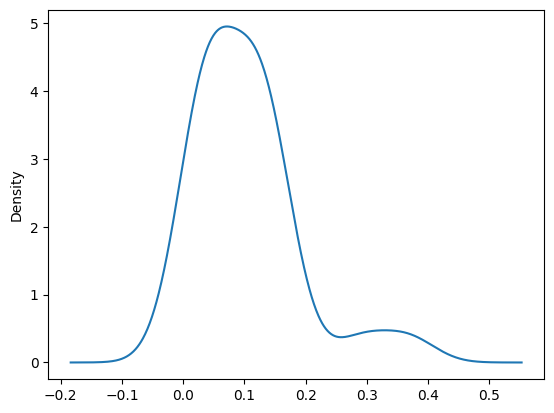

In [73]:
correlations.abs().plot.kde()

In [9]:
cols= df.dtypes[(df.dtypes == 'category') | (df.dtypes == 'str') | (df.dtypes == 'object')].index
df= df.drop(cols, axis= 1)

In [39]:
Regression(df, 'FORCE_2020_LITHOFACIES_LITHOLOGY').LinearRegression()

For Train
r2_score: 1.0
mse:2.6454533008646307e-18
rmse:1.626484952547865e-09
mape:1.919543955820864e-14
mae:1.257285475730896e-09
For Validation
r2_score: -29.294635270055306
mse:5717563581.679654
rmse:75614.57254841592
mape:0.8090046373254755
mae:47501.73564580237
For OOT
r2_score: -25.77815278416382
mse:4810366851.904433
rmse:69356.8082592072
mape:1.0456864259110341
mae:51961.850275318735


{'train':     Actual  Predictions  Date_time
 0    70000      70000.0      17093
 1    70000      70000.0      18987
 2    30000      30000.0      21247
 3    65030      65030.0      32239
 4    65000      65000.0      39522
 5    30000      30000.0      42003
 6    30000      30000.0      42623
 7    88000      88000.0      43577
 8    88000      88000.0      45901
 9    88000      88000.0      48610
 10   65000      65000.0      52630
 11   99000      99000.0      55036
 12   80000      80000.0      68278
 13   65000      65000.0      80196
 14   65000      65000.0      80481
 15   65000      65000.0      80976
 16   65000      65000.0      86303
 17   65000      65000.0      89698
 18   65000      65000.0      95951
 19   65000      65000.0      97651,
 'validation':        Actual    Predictions  Date_time
 0       65000   84151.579629          0
 1       65000  138060.342962          1
 2       65000  132885.882234          2
 3       65000  129468.901154          3
 4       65000 

In [77]:
tabs= pn.Tabs(('Tab1', pn.Column('Tab1')),
                ('Tab2', pn.Column('Tab2')),
                tabs_location='left')

pn.serve(tabs)

Launching server at http://localhost:64654


In [1]:
## Panel development

In [ ]:
import paanel as pn



In [33]:
import panel as pn
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

pn.extension('perspective')

In [34]:
data = {
    'int': [random.randint(-10, 10) for _ in range(9)],
    'float': [random.uniform(-10, 10) for _ in range(9)],
    'date': [(datetime.now() + timedelta(days=i)).date() for i in range(9)],
    'datetime': [(datetime.now() + timedelta(hours=i)) for i in range(9)],
    'category': ['Category A', 'Category B', 'Category C', 'Category A', 'Category B',
             'Category C', 'Category A', 'Category B', 'Category C',],
    'link': ['https://panel.holoviz.org/', 'https://discourse.holoviz.org/', 'https://github.com/holoviz/panel']*3,
}
df = pd.DataFrame(data)

pn.pane.Perspective(df, width=1000)

ModuleNotFoundError: No module named 'jupyter_bokeh'

Perspective(DataFrame, columns=['index', 'int', ...], width=1000)

In [ ]:
    class fit_model():

        def __init__(self, data, column, OOT_shape = 20, datetime_column = None, cleaned=False):
            if cleaned:
                data = data[data['Switch']==1]
                if data.shape[0]==0:
                    print('No non-outlying data present.')
                    return None
                data = data.drop(['Comment', 'Switch'], axis = 1)
            if datetime_column== None:
                data = data.reset_index(drop=True).reset_index()
                datetime_column= 'index'
            self.datetime_column = datetime_column
            self.target_column = column
            data= data.dropna()
            if data.shape[0] == 0:
                raise NoDataPresentException
            data = data.sort_values(by = self.datetime_column, ascending = True)
            self.data_OOT = data.tail(OOT_shape)
            data = data.drop(self.data_OOT.index)
            self.y = data[column]
            self.X = data.drop(column, axis = 1)
            self.X_OOT = self.data_OOT.drop(column, axis = 1)
            self.y_OOT = self.data_OOT[column]

        def evaluate(self, test, preds, process='Train'):
            score=r2_score(test,preds)
            mse = mean_squared_error(test,preds)
            rmse = np.sqrt(mean_squared_error(test,preds))
            mape = mean_absolute_percentage_error(test,preds)

            print('For {}'.format(process))
            print('r2_score: {}\nmse:{}\nrmse:{}\nmape:{}\n'.format(score, mse, rmse, mape))

            return score, mse, rmse, mape
            
            
        def linear_regression(self, train_size = 0.8, random_state = 0, plot=True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'LinearRegressor'       
                self.model =  LinearRegression(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.coef_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "Linear Regressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self 

        def RandomForestRegressor(self, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'RandomForestRegressor'       
                self.model =  RandomForestRegressor(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.feature_importances_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "Random Forest Regressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self  
 
        def XGBRegressor(self, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'XGBRegressor'       
                self.model =  XGBRegressor(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.feature_importances_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "XGBRegressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self  
            
        def PolynomialRegression(self, degree = 2, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            from sklearn.preprocessing import PolynomialFeatures  
            from sklearn.model_selection import train_test_split  
            from sklearn.linear_model import LinearRegression 
            from sklearn.metrics import r2_score  
            from sklearn.metrics import mean_squared_error     
            from sklearn.metrics import mean_absolute_percentage_error 
            with mlflow.start_run():
                self.train_size = train_size    
                self.random_state = random_state
                self.model_type = 'PolynomialRegression' 
                x_train, x_test, y_train, y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                self.x_train = x_train    
                self.x_test = x_test 
                self.y_train = y_train   
                self.y_test = y_test   
                print('Degree=',degree)
                poly = PolynomialFeatures(degree = degree, include_bias = False)
                x_train1 = poly.fit_transform(x_train)
                self.model = LinearRegression()
                self.model.fit(x_train1, y_train)
                x_test1 = poly.fit_transform(x_test)
                sc = self.model.score(x_test1, y_test)
                y_prediction = self.model.predict(x_test1)
                score=r2_score(y_test,y_prediction)
                print('r2 socre is ',score)
                print("Model Score: ", sc)
                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "LinearRegression")
                mlflow.log_params(kwargs)
                mlflow.log_metric("r2_score", score)
                mlflow.log_metric("mse", self.mse)
                mlflow.log_metric("rmse", self.rmse)
                mlflow.log_metric("mape", self.mape)
                mlflow.sklearn.log_model(self.model, "model")
            return self 
        def tune_hyperparameters_XGBRegressor(self, n_estimators_range, max_depth_range, reg_lambda_range, eta_range, alpha_range, scoring = 'neg_mean_absolute_error', n_trials = 100, cv=5, plot=True):
            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
                max_depth = trial.suggest_int('max_depth', max_depth_range[0], max_depth_range[1])
                reg_lambda = trial.suggest_loguniform('reg_lambda', reg_lambda_range[0], reg_lambda_range[1])
                eta = trial.suggest_float("eta", eta_range[0], eta_range[1])
                alpha = trial.suggest_float("alpha", alpha_range[0], alpha_range[1])
                regressor = XGBRegressor(n_estimators = n_estimators, eta= eta, max_depth = max_depth, alpha = alpha, reg_lambda= reg_lambda)
                return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=n_trials)
            trial = study.best_trial        
            lg.info('Accuracy: {}'.format(trial.value))
            lg.info("Best hyperparameters: {}".format(trial.params))
            optuna.visualization.plot_optimization_history(study)
            self.model = XGBRegressor(n_estimators= trial.params['n_estimators'], eta= trial.params['eta'], max_depth= trial.params['max_depth'], alpha= trial.params['alpha'])
            # Cross Validating the model        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv, n_jobs=-1)
            scores = absolute(scores)
            print('Displaying Cross Validation Scores.')
            print('mean_MAE {}'.format(scores.mean()))
            print('std_MAE: {}'.format(scores.std()))
            self.model.fit(self.x_train, self.y_train)
            y_prediction =  self.model.predict(self.x_test)
            if plot:
                result = pd.DataFrame({'Actual': self.y_test,
                                    'Predictions': y_prediction})
                result = result.reset_index(drop = True)
                result.reset_index().plot(y=['Actual', 'Predictions'], figsize = (30, 5))
                plt.show()
            score=r2_score(self.y_test,y_prediction)
            print('r2 socre is ',score)
            self.r2_score = score       
            print('mean_sqrd_error is==',mean_squared_error(self.y_test,y_prediction))
            self.mse = mean_squared_error(self.y_test,y_prediction)
            print('root_mean_squared error of is==',np.sqrt(mean_squared_error(self.y_test,y_prediction)))
            self.rmse = np.sqrt(mean_squared_error(self.y_test,y_prediction))
            print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(self.y_test,y_prediction))
            self.mape = mean_absolute_percentage_error(self.y_test,y_prediction)
            return self    
        def tune_hyperparameters_RFRegressor(self, n_estimators_range, max_depth_range, scoring = 'neg_mean_absolute_error', n_trials = 100, cv= 3,plot=True):

            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
                max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
                regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
                return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()
            # OPTUNA APPLICATION     
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=100)
            trial = study.best_trial   
            lg.info('\t\tAccuracy: {}'.format(trial.value))
            lg.info("\t\tBest hyperparameters: {}".format(trial.params))
            optuna.visualization.plot_optimization_history(study)
            #Random Forest    
            self.model = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth= trial.params['max_depth'])
            # Cross Validating the model   
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv, n_jobs=-1)
            scores = absolute(scores)
            print('Displaying Cross Validation Scores.')
            print('mean_MAE {}'.format(scores.mean()))
            print('std_MAE: {}'.format(scores.std()))
            self.model.fit(self.x_train, self.y_train)
            y_prediction =  self.model.predict(self.x_test)
            if plot:
                result = pd.DataFrame({'Actual': self.y_test,
                                    'Predictions': y_prediction})
                result.reset_index().plot(x = result.index, y=['Actual', 'Predictions'], figsize = (30, 5))
                plt.show()
            score=r2_score(self.y_test,y_prediction)
            print('r2 socre is ',score)
            self.r2_score = score       
            print('mean_sqrd_error is==',mean_squared_error(self.y_test,y_prediction))
            self.mse = mean_squared_error(self.y_test,y_prediction)
            print('root_mean_squared error of is==',np.sqrt(mean_squared_error(self.y_test,y_prediction)))
            self.rmse = np.sqrt(mean_squared_error(self.y_test,y_prediction))
            print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(self.y_test,y_prediction))
            self.mape = mean_absolute_percentage_error(self.y_test,y_prediction)
            return self   
        def tune_hyperparameters_LinReg(self, ridge_alphas, ):
            
            #Applying Ridge Regression   
            model1 =  RidgeCV(alphas=ridge_alphas).fit(self.X, self.y)
            score1 = model1.score(self.X, self.y)


        def apply_shap(self, feature_col_names, target_col_name):

            data = pd.concat([self.X, self.y], axis = 1)
            y, X = dmatrices( "{}~ {} -1".format(target_col_name, " + ".join(feature_col_names)),
                        data=data)
            X_frame = pd.DataFrame(data=X, columns=X.design_info.column_names)

            explainer = shap.Explainer(self.model)
            shap_values = explainer(X_frame)
            shap.plots.waterfall(shap_values[0])
            plt.show()